In [1]:
# pip install pandas scikit-learn matplotlib

In [2]:
from pathlib import Path
import os

import utils as u

In [3]:
notebook_path = Path(os.path.abspath("."))
data_path = notebook_path.parent / "docs" / "data"

# EVALUATION

## NHL

In [4]:
prediction_files, results_files = u.get_prediction_results_filepaths(league="nhl", root=data_path)

df = u.make_dataframe(pred_filepaths=prediction_files, res_filepaths=results_files, total_line=6.5, hcp_line=1.5)
df.head(2)

,match_id,start_time_utc,home_team,away_team,ft_home_prob,ou_prob,hcp_prob,home_team_score,away_team_score,ft_home_won,ou_won,hcp_won
0,2025020338,2025-11-23T00:00:00,Florida Panthers,Edmonton Oilers,0.5131,0.4313,0.7395,3,6,False,True,False
1,2025020461,2025-12-09T00:30:00,Toronto Maple Leafs,Tampa Bay Lightning,0.3402,0.4941,0.5672,2,0,True,False,True


=== Evaluation Summary ===
                       n  prevalence  brier  logloss    auc  acc@0.5
metric                                                              
FT Home Win          468      0.5256 0.2556   0.7048 0.5107   0.5150
Totals (Over/Under)  468      0.4744 0.2503   0.6937 0.5113   0.5214
Asian Handicap       468      0.7500 0.1919   0.5737 0.5179   0.7479


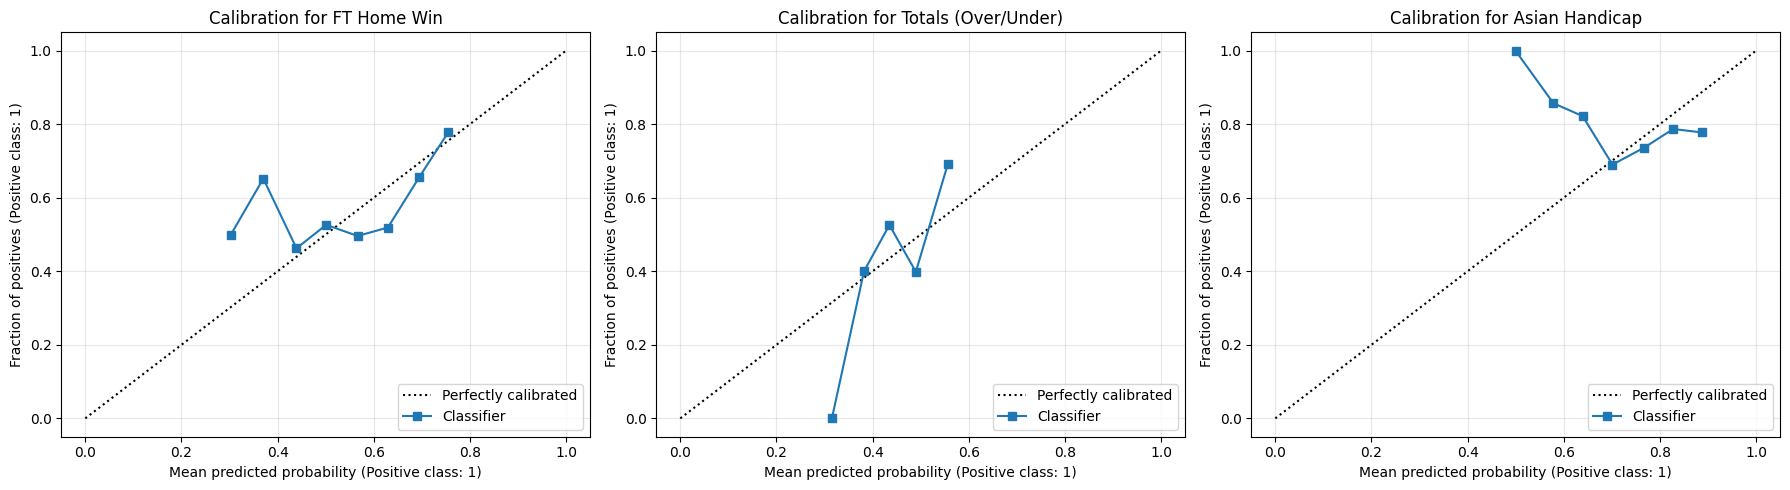

In [5]:
# Evaluate everything
_ = u.evaluate_calibration(df=df, n_bins=15)

=== Evaluation Summary ===
                       n  prevalence  brier  logloss    auc  acc@0.5
metric                                                              
FT Home Win          328      0.5244 0.2536   0.7002 0.5232   0.5122
Totals (Over/Under)  328      0.4756 0.2503   0.6937 0.5159   0.5061
Asian Handicap       328      0.7470 0.1951   0.5799 0.5040   0.7439


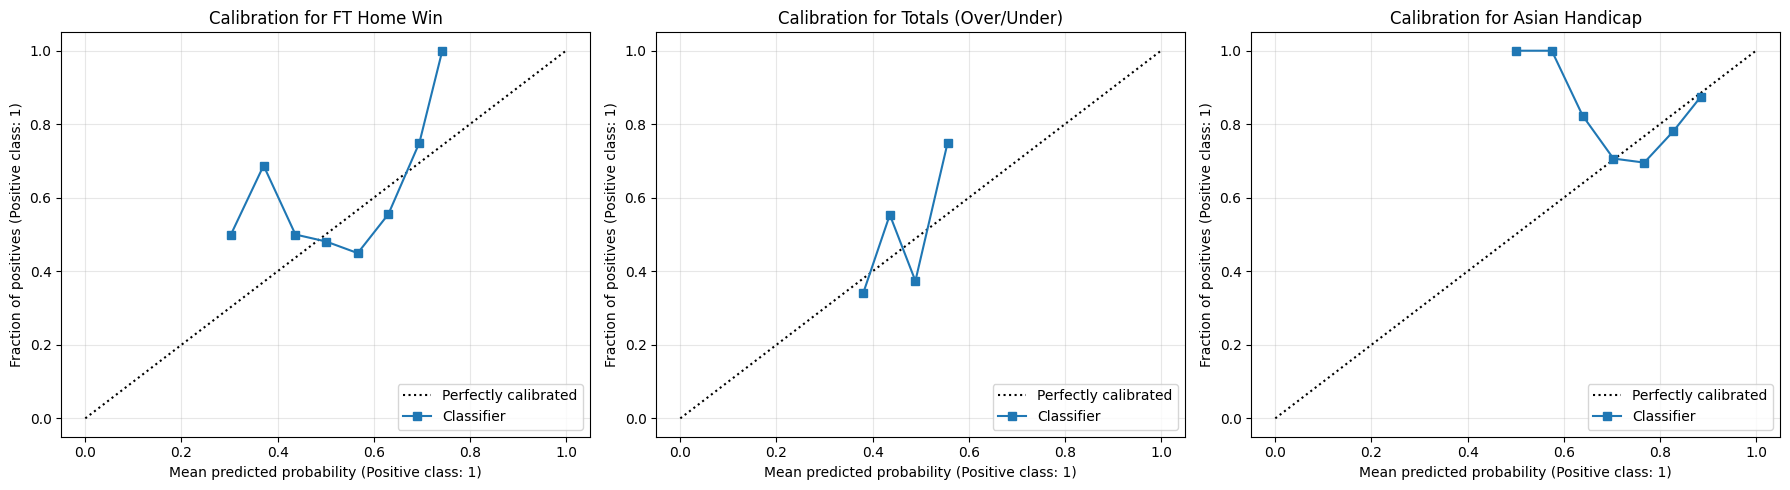

In [6]:
# Evaluate matches only after major bugfix
after_bug_df = df[df["start_time_utc"]>="2025-10-29 15:00:00"].copy()
_ = u.evaluate_calibration(df=after_bug_df, n_bins=15)

## NBA

In [7]:
prediction_files, results_files = u.get_prediction_results_filepaths(league="nba", root=data_path)

df = u.make_dataframe(pred_filepaths=prediction_files, res_filepaths=results_files, total_line=225.5, hcp_line=8.5)
df.head(2)

,match_id,start_time_utc,home_team,away_team,ft_home_prob,ou_prob,hcp_prob,home_team_score,away_team_score,ft_home_won,ou_won,hcp_won
0,0022500264,2025-11-21T00:00:00,Orlando Magic,Los Angeles Clippers,0.3465,0.3498,0.5706,129,101,True,True,True
1,0022500338,2025-12-06T00:00:00,Boston Celtics,Los Angeles Lakers,0.8098,0.7417,0.9232,126,105,True,True,True


=== Evaluation Summary ===
                       n  prevalence  brier  logloss    auc  acc@0.5
metric                                                              
FT Home Win          180      0.5333 0.2219   0.6323 0.6917   0.6222
Totals (Over/Under)  180      0.5944 0.2518   0.7053 0.6180   0.5889
Asian Handicap       180      0.7389 0.1682   0.5031 0.7333   0.7500


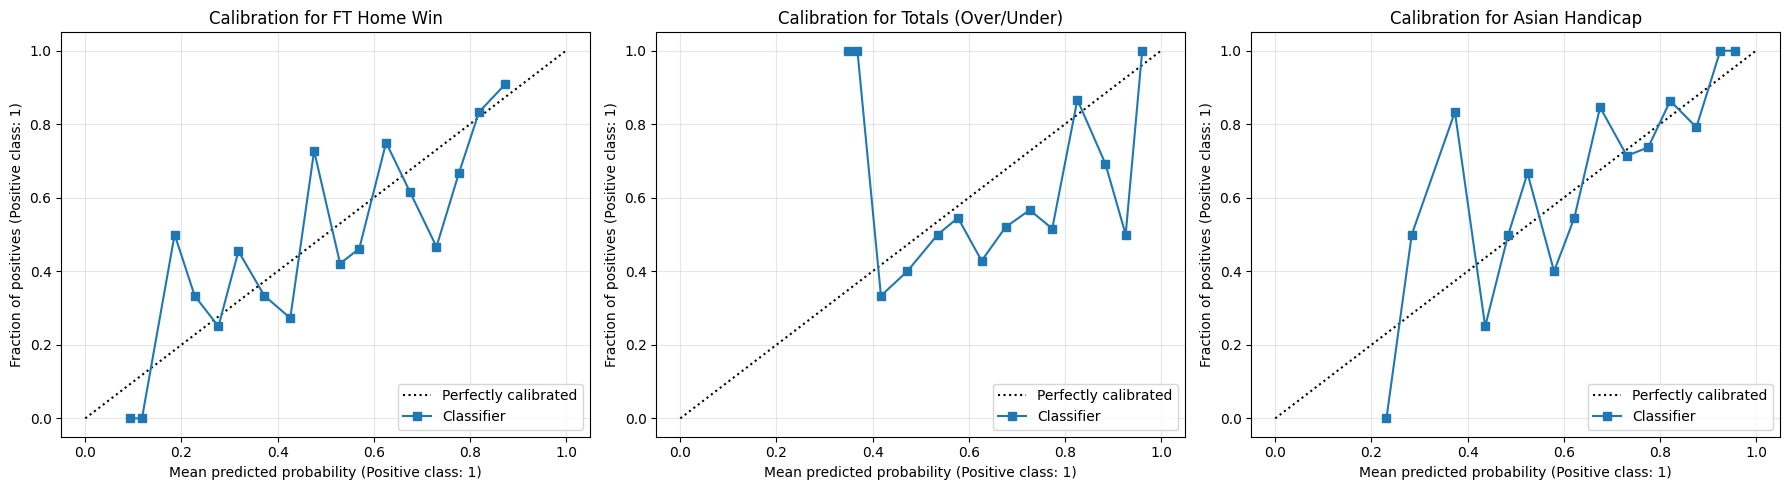

In [8]:
_ = u.evaluate_calibration(df=df, n_bins=20)